In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import sys
sys.path.append("../")

from evaluate_script import predict, predict_with_removal, calculate_removal_error

# Get Metadata

In [ ]:
df = pd.read_csv('../data/exams.csv')
df.head()

In [ ]:
df_meta = pd.read_csv("../data/average_beat_metadata.csv")
df_meta.head()

In [ ]:
df = pd.merge(
    df_meta,
    df[['exam_id', 'age', 'nn_predicted_age']],
    how='left', # to keep the same order of exam_ids
    on='exam_id',
)
df.head()

# Prediction for zero filled average beat

In [ ]:
data_array = np.load("../data/one_beat_array.npy")
pred_zero_fill = predict(data_array)

## Replace zero fill values with the first and the last pixel values, per channel, per subject

In [ ]:
for i in range(len(data_array)):
    i = 0
    
    for chan in range(12):
        chan = 0
        arr = data_array[i, :, chan]
        
        idx_min = int((np.nonzero(arr))[0][0])
        begin_fill = arr[idx_min]
        
        idx_max = int((np.nonzero(arr))[0][-1])
        end_fill = arr[idx_max]
        data_array[i, :idx_min, chan] = begin_fill
        data_array[i, idx_max:, chan] = end_fill

In [ ]:
pred_dc_fill = predict(data_array)

In [ ]:
plt.scatter(
    pred_zero_fill,
    pred_dc_fill,
)

### Only the 0th subject shows some difference in predictions

In [ ]:
(abs(pred_dc_fill - pred_zero_fill) > 0.05)

In [ ]:
# data_array = np.load("../data/one_beat_array.npy")
for chan in range(12):
    plt.plot(data_array[0, 1800:2450, chan], label=chan)
plt.legend()
plt.show()

In [ ]:
# data_array = np.load("../data/one_beat_array.npy")
subject = 123
for chan in range(12):
    plt.plot(data_array[subject, 1800:2450, chan], label=chan)
plt.legend()
plt.show()

# Replace 2 seconds (2000 Hz) before the QRS peak by 0 and predict

In [ ]:
data_array[:, 2046:2048, :] = 0
pred_200hz_asc = predict(data_array)

In [ ]:
plt.scatter(
    pred_zero_fill,
    pred_2000hz_asc,
    alpha=0.5
)
plt.title("Avg Beat Pred VS Removed 2000 Hz ascending QRS")
plt.show()

# Replace 2 seconds before QRS peak by the value at 3 second before

In [ ]:
data_array = np.load("../data/one_beat_array.npy")
pred_2000hz_dc_asc = predict_with_removal(data_array, 2046, 2)

In [ ]:
plt.scatter(
    pred_zero_fill,
    pred_2000hz_dc_asc,
    alpha=0.2,
)
plt.title("Avg Beat Pred VS Removed 2000 Hz DC ascending QRS")
plt.show()

In [ ]:
data_array = np.load("../data/one_beat_array.npy")
pred_2000hz_ac_desc = predict_with_removal(data_array, 2048, 2)

In [ ]:
plt.scatter(
    pred_zero_fill,
    pred_2000hz_ac_desc,
    alpha=0.2,
)
plt.title("Avg Beat Pred VS Removed 2000 Hz DC ascending QRS")
plt.show()

In [ ]:
plt.scatter(
    pred_zero_fill,
    pred_2000hz_dc_asc,
    alpha=0.2,
    label='ascending',
)
plt.scatter(
    pred_zero_fill,
    pred_2000hz_ac_desc,
    alpha=0.2,
    label='descending',
)
plt.legend()
plt.title("Avg Beat Pred VS Removed 2000 Hz DC QRS")
plt.show()


In [3]:
# Don't use the whole array for small experiments; use only top 1000
df_err = calculate_removal_error(
    data_array_loc="../data/one_beat_array.npy",
    interval=20,
    n=10,
)

In [4]:
df_err.to_csv("error_20_sec.csv", index=False)

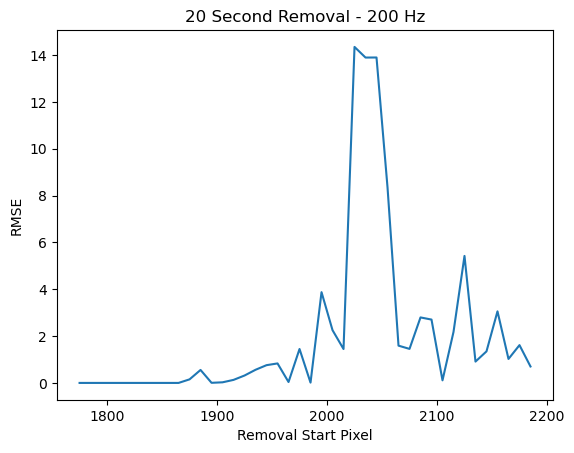

In [8]:
plt.title("20 Second Removal - 200 Hz")
plt.ylabel('RMSE')
plt.xlabel('Removal Start Pixel')
plt.plot(df_err['start_pixel'], df_err['rmse'])